# 이상 탐지 분류 모델 (Binary classification)

## 라이브러리 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('fivethirtyeight')
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from collections import Counter
import missingno as msno

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Feature와 label이 기록되어 있는 데이터셋을 불러온다.

In [ ]:
data = pd.read_csv('drive/MyDrive/230808/uci-secom_rev.csv')

In [ ]:
data = data.drop(columns = ['Time'], axis = 1)
data.shape

(1586, 591)

Label의 갯수를 확인한 후, label 값을 재설정한다.

In [ ]:
unique_vals = data['Pass/Fail'].unique()
print(unique_vals)

[-1  1]


In [ ]:
data['Pass/Fail'] = data['Pass/Fail'].replace(-1,0).astype('int64')
data['Pass/Fail'].value_counts()

0    1463
1     123
Name: Pass/Fail, dtype: int64

## 데이터 전처리

In [ ]:
num_null = data.isnull().sum().sum()
data = data.replace(np.NaN, 0)

In [ ]:
x = data.iloc[:,:590]
y = data["Pass/Fail"]

print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1586, 590)
shape of y: (1586,)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1110, 590)
shape of x_test:  (476, 590)
shape of y_train:  (1110,)
shape of y_test:  (476,)


In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## 전처리한 데이터를 이용하여 Logistic Regression model 또는 XGBoost classifier를 학습한다.

In [ ]:
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  94.11764705882352


<AxesSubplot: >

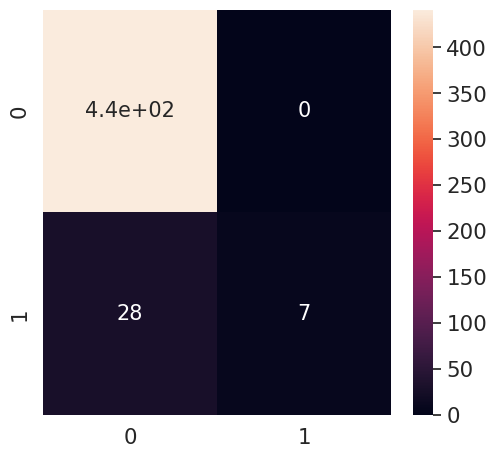

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

### [상황 설명]
- 전처리한 데이터를 사용하여 XGBoost를 바로 학습하는 것은 성능이 낮은 상황이다.
- 데이터 처리와 모델 구성의 변화를 통해 성능을 향상시켜 본다.

In [ ]:
signal=pd.read_csv('drive/MyDrive/230808/uci-secom_rev.csv')

In [ ]:
signal['Pass/Fail'] = signal['Pass/Fail'].replace(-1,0).astype('int64')

### Time index 처리

In [ ]:
from datetime import datetime
signal['year'] = pd.DatetimeIndex(signal['Time']).year
signal['month'] = pd.DatetimeIndex(signal['Time']).month
signal['date'] = pd.DatetimeIndex(signal['Time']).day
signal['week_day'] = pd.DatetimeIndex(signal['Time']).weekday
signal['start_time'] = pd.DatetimeIndex(signal['Time']).time
signal['hour'] = pd.DatetimeIndex(signal['Time']).hour
signal['min'] = pd.DatetimeIndex(signal['Time']).minute
signal = signal.drop('Time',axis=1)

In [ ]:
signal.head()

,0,1,2,3,4,5,6,7,8,9,...,588,589,Pass/Fail,year,month,date,week_day,start_time,hour,min
0,2989.82,2434.00,2180.0556,1031.0669,0.7565,100.0,104.7056,0.1226,1.5865,0.0080,...,0.0024,79.8045,0,2008,8,22,4,00:44:00,0,44
1,3017.53,2524.09,2201.0667,880.2317,1.4148,100.0,106.5478,0.1211,1.3720,-0.0005,...,0.0068,71.5333,0,2008,1,9,2,20:51:00,20,51
2,3032.89,2500.81,2183.4333,1582.5646,1.3601,100.0,99.0267,0.1240,1.4615,-0.0034,...,0.0055,114.4127,0,2008,3,8,5,17:00:00,17,0
3,3037.92,2361.50,2210.9778,1572.4698,1.0204,100.0,106.2089,0.1222,1.5251,0.0468,...,0.0030,25.1494,0,2008,4,9,2,17:30:00,17,30
4,2982.67,2541.55,2173.4889,1145.7970,0.9402,100.0,104.0556,0.1247,1.3762,-0.0206,...,0.0108,237.4625,0,2008,3,10,0,02:41:00,2,41


In [ ]:
print(signal.year.unique())
print(signal.month.unique())
print(signal.week_day.unique())
print(signal.hour.unique())

[2008]
[ 8  1  3  4  9  7 10  6 12  2  5 11]
[4 2 5 0 1 6 3]
[ 0 20 17  2 21  3 15 19 23  4 14 12 10 11  7  8  1  6  5 22 13  9 16 18]


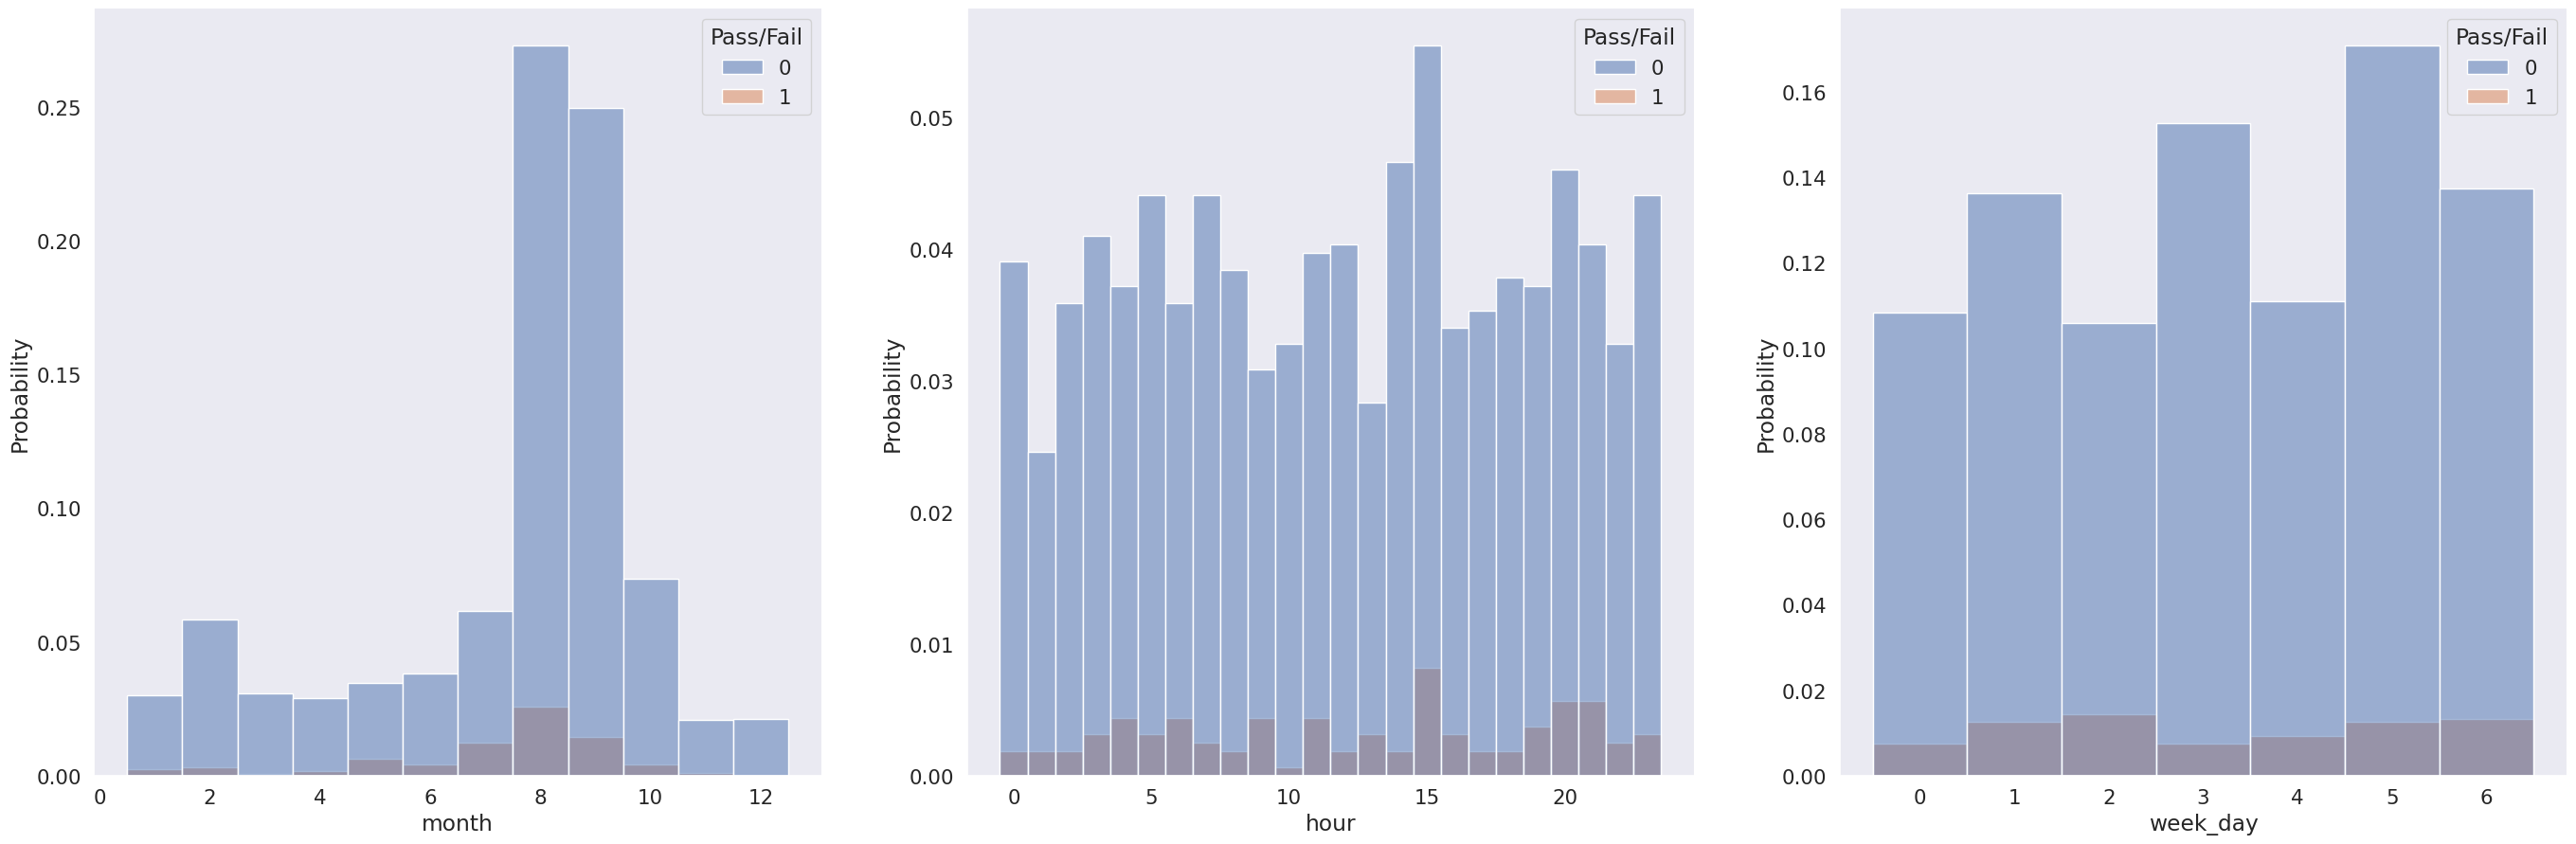

In [ ]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)

sns.histplot(data=signal, x="month", hue="Pass/Fail",stat="probability", discrete=True,);
sns.despine(right=True,top=True)


plt.subplot(1, 3, 2)

sns.histplot(data=signal, x="hour", hue="Pass/Fail",stat="probability", discrete=True,);
sns.despine(right=True,top=True)


plt.subplot(1, 3, 3)

sns.histplot(data=signal, x="week_day", hue="Pass/Fail",stat="probability", discrete=True,);
sns.despine(right=True,top=True)

In [ ]:
signal_df=signal.drop(['year','month','date','week_day','start_time','hour','min'],1)

/tmp/ipykernel_26273/3486755128.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  signal_df=signal.drop(['year','month','date','week_day','start_time','hour','min'],1)


In [ ]:
signal_df.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2989.82,2434.00,2180.0556,1031.0669,0.7565,100.0,104.7056,0.1226,1.5865,0.0080,...,NaN,0.4952,0.0136,0.0041,2.7510,0.0104,0.0083,0.0024,79.8045,0
1,3017.53,2524.09,2201.0667,880.2317,1.4148,100.0,106.5478,0.1211,1.3720,-0.0005,...,NaN,0.4998,0.0097,0.0026,1.9495,0.0328,0.0235,0.0068,71.5333,0
2,3032.89,2500.81,2183.4333,1582.5646,1.3601,100.0,99.0267,0.1240,1.4615,-0.0034,...,114.4127,0.4961,0.0124,0.0036,2.4896,0.0155,0.0177,0.0055,114.4127,0
3,3037.92,2361.50,2210.9778,1572.4698,1.0204,100.0,106.2089,0.1222,1.5251,0.0468,...,NaN,0.4965,0.0186,0.0042,3.7541,0.0335,0.0084,0.0030,25.1494,0
4,2982.67,2541.55,2173.4889,1145.7970,0.9402,100.0,104.0556,0.1247,1.3762,-0.0206,...,NaN,0.4949,0.0146,0.0033,2.9448,0.0137,0.0326,0.0108,237.4625,0


### Feature engineering

In [ ]:
empty_cols = signal.columns[signal.isna().mean()>=.15]
empty_cols.shape

(52,)

In [ ]:
signal_df1 = signal_df.drop(empty_cols,axis=1)
signal_df1.shape

(1586, 539)

In [ ]:
column = signal_df.columns

In [ ]:
nunique = signal_df1.apply(pd.Series.nunique)
nunique

0            1520
1            1504
2             507
3             518
4             503
             ... 
586           322
587           260
588           120
589           611
Pass/Fail       2
Length: 539, dtype: int64

In [ ]:
const_cols = nunique[nunique == 1].index
const_cols.shape

(116,)

In [ ]:
signal_df2 = signal_df1.drop(const_cols,axis=1)
signal_df2.shape

(1586, 423)

In [ ]:
signal_df2.isnull().sum().sum()

2757

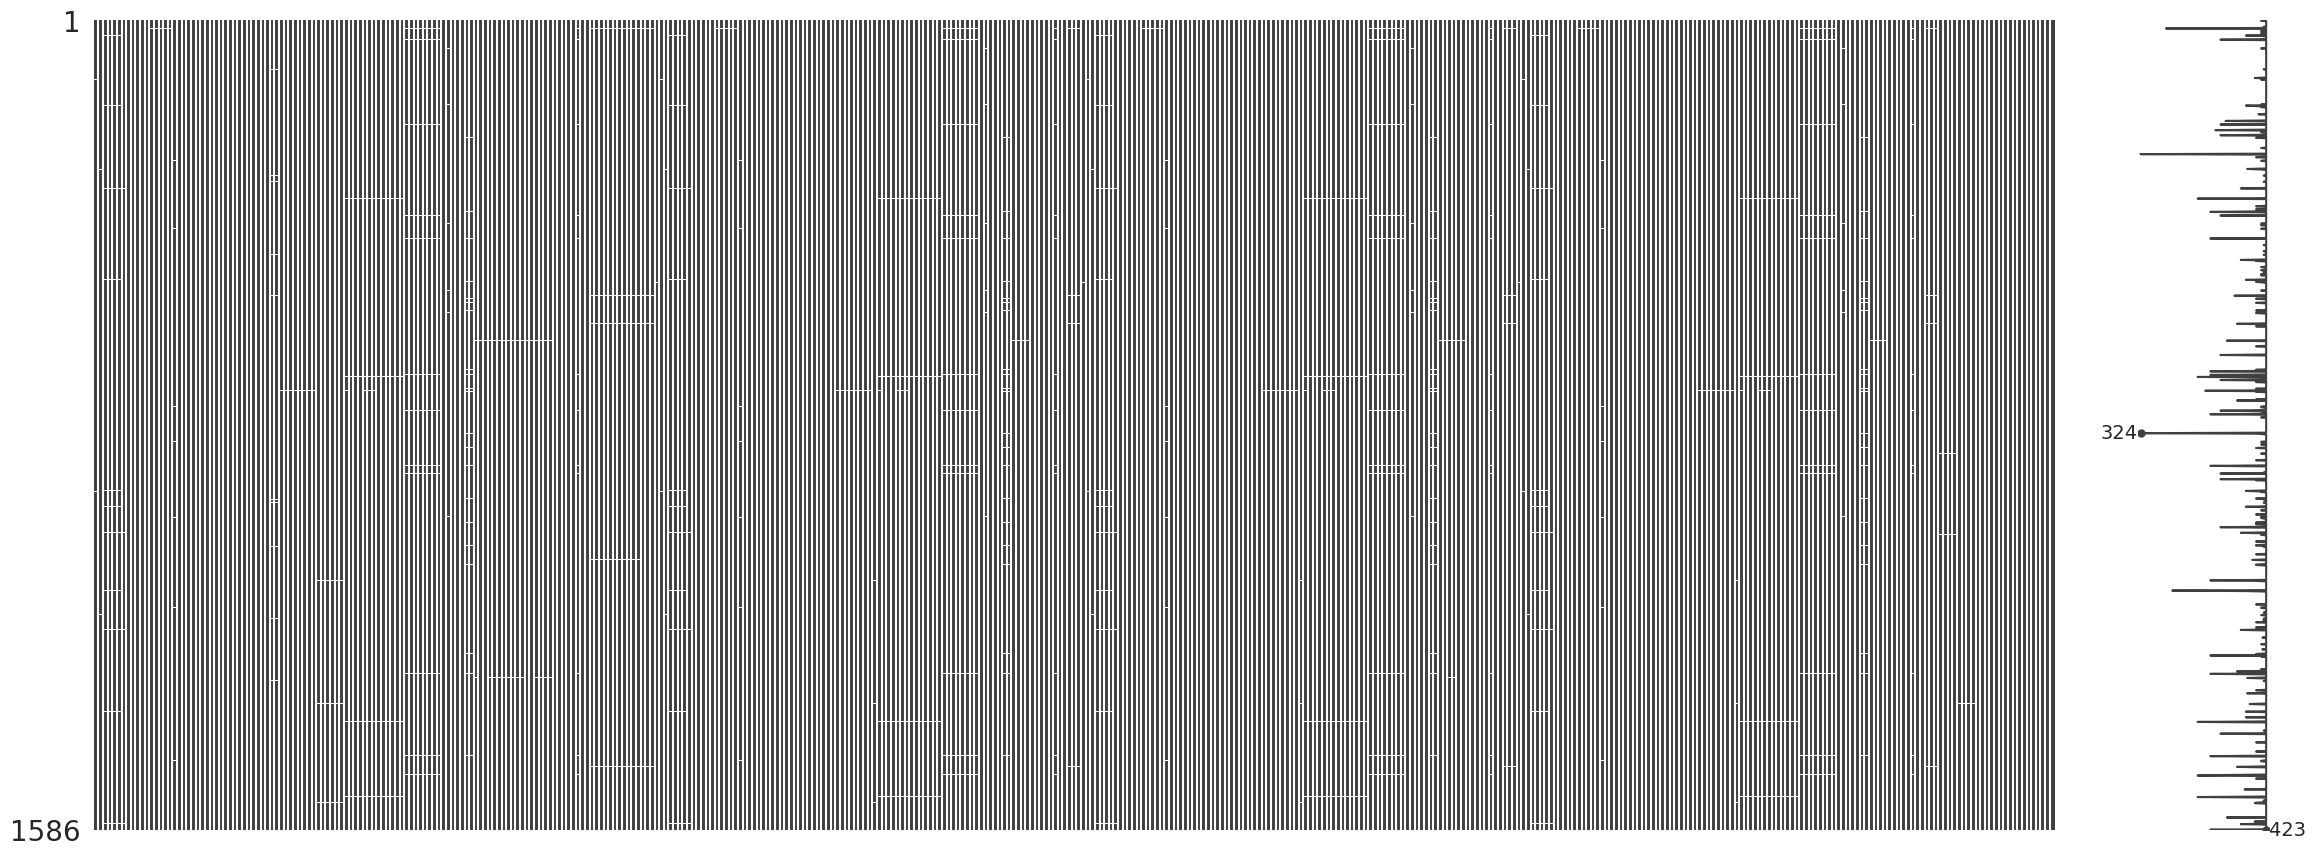

In [ ]:
msno.matrix(signal_df2);

### Imputation

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
array = imputer.fit_transform(signal_df2)

In [ ]:
cols=signal_df2.columns

In [ ]:
signal_df3 = pd.DataFrame(array, columns = cols)

In [ ]:
signal_df3.head()

,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,2989.82,2434.00,2180.0556,1031.0669,0.7565,104.7056,0.1226,1.5865,0.0080,-0.0216,...,15.3151,0.4952,0.0136,0.0041,2.7510,0.0104,0.0083,0.0024,79.8045,0.0
1,3017.53,2524.09,2201.0667,880.2317,1.4148,106.5478,0.1211,1.3720,-0.0005,0.0052,...,17.2719,0.4998,0.0097,0.0026,1.9495,0.0328,0.0235,0.0068,71.5333,0.0
2,3032.89,2500.81,2183.4333,1582.5646,1.3601,99.0267,0.1240,1.4615,-0.0034,-0.0042,...,17.0931,0.4961,0.0124,0.0036,2.4896,0.0155,0.0177,0.0055,114.4127,0.0
3,3037.92,2361.50,2210.9778,1572.4698,1.0204,106.2089,0.1222,1.5251,0.0468,-0.0010,...,12.5432,0.4965,0.0186,0.0042,3.7541,0.0335,0.0084,0.0030,25.1494,0.0
4,2982.67,2541.55,2173.4889,1145.7970,0.9402,104.0556,0.1247,1.3762,-0.0206,-0.0104,...,13.5037,0.4949,0.0146,0.0033,2.9448,0.0137,0.0326,0.0108,237.4625,0.0


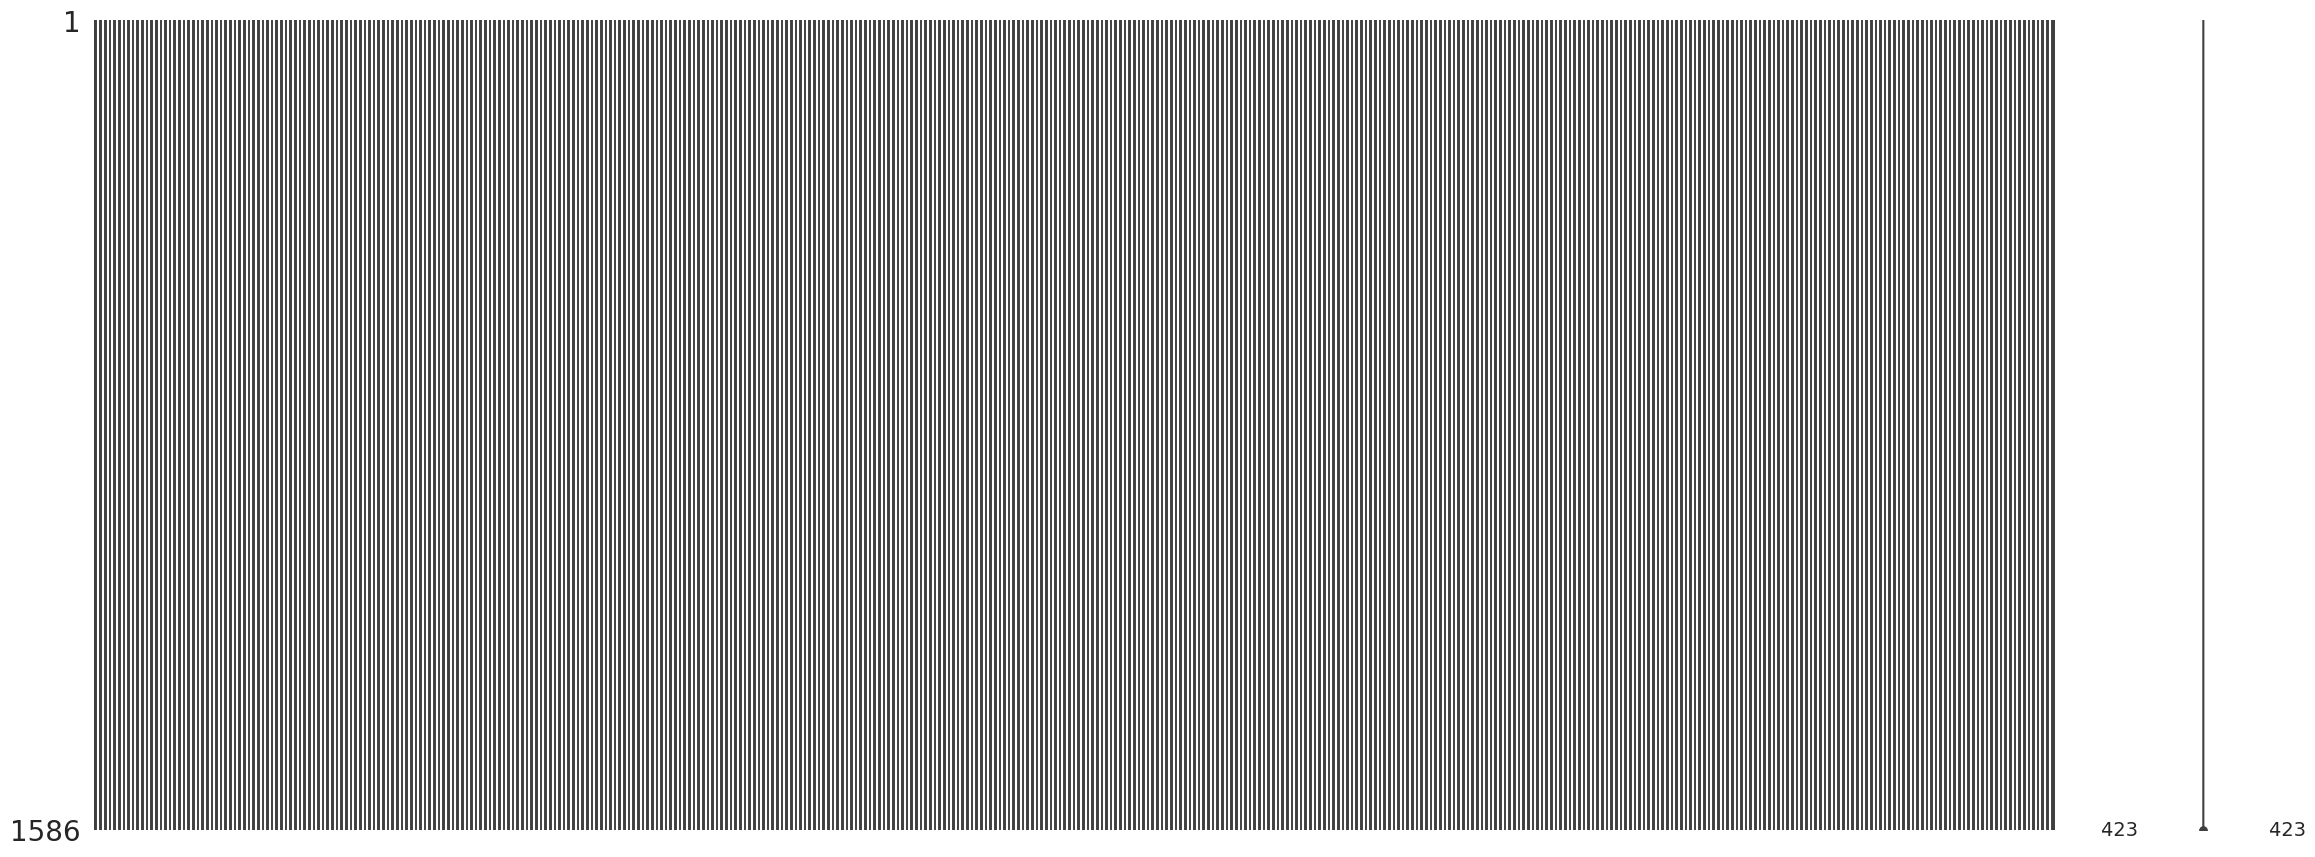

In [ ]:
msno.matrix(signal_df3);

### Correlated features

Text(0.5, 1.0, 'Correlation heatmap for the Data')

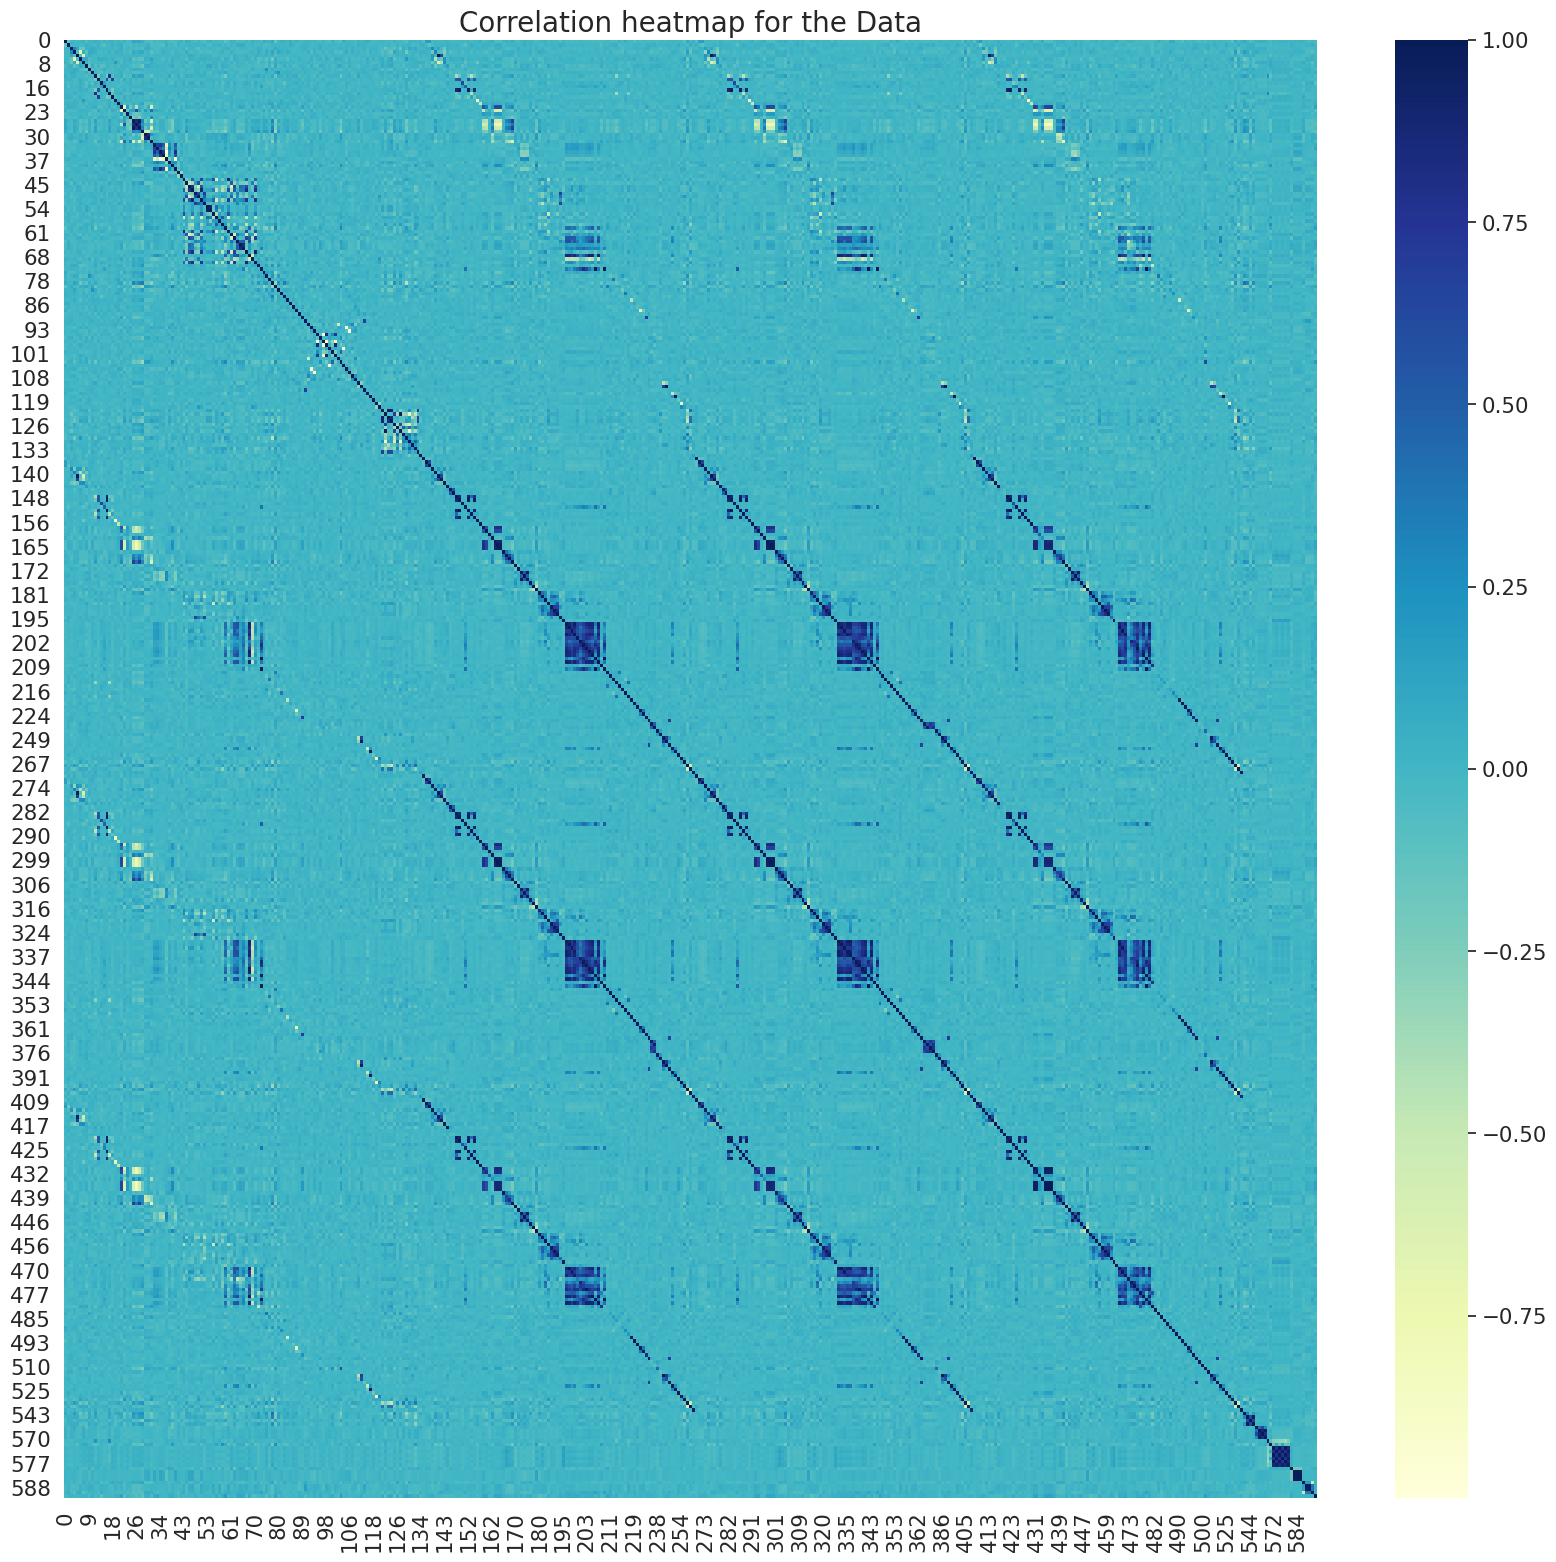

In [ ]:
plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(signal_df3.corr(), cmap = "YlGnBu")
plt.title('Correlation heatmap for the Data', fontsize = 20)

In [ ]:
# Create correlation matrix
corr_matrix = signal_df3.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop1 = [column for column in upper.columns if any(upper[column] < -0.9)]
to_drop2 = [column for column in upper.columns if any(upper[column] > 0.9)]
drop=to_drop1+to_drop2
df=signal_df3.drop(drop,1)

/tmp/ipykernel_26273/1707152736.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=signal_df3.drop(drop,1)


In [ ]:
feature = df.drop("Pass/Fail", 1)
y = df["Pass/Fail"]
col = list(feature.columns)

/tmp/ipykernel_26273/3049454096.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature = df.drop("Pass/Fail", 1)


### Outlier

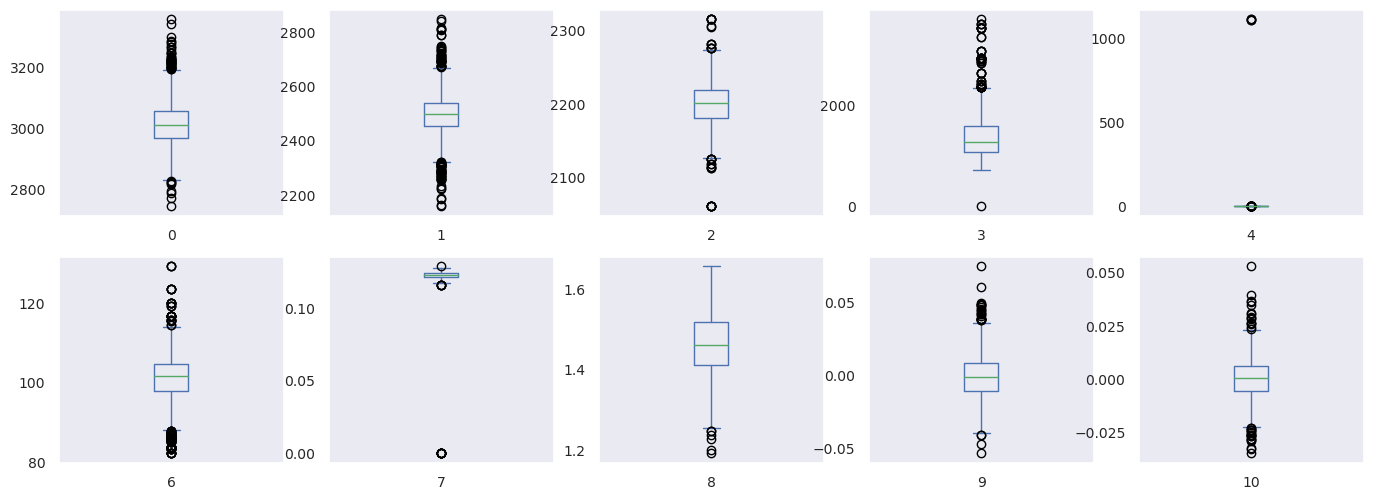

In [ ]:
feature.iloc[:, :10].plot(kind='box', subplots=True,layout=(10,5), fontsize=10, figsize=(15,30));

In [ ]:
from scipy import stats

def outliers_high(feat):
    q1= feat.quantile(.25)
    q2= feat.quantile(.5)
    q3= feat.quantile(.75)
    feat = np.where(feat > q3+ stats.iqr(feat),q2,feat)
    return feat

def outliers_low(feat):
    q1= feat.quantile(.25)
    q2= feat.quantile(.5)
    q3= feat.quantile(.75)
    feat = np.where(feat < q1 - stats.iqr(feat),q2,feat)
    return feat

In [ ]:
x=feature.copy()
for column in feature:
    x[column] = outliers_high(x[column])
    x[column] = outliers_low(x[column])

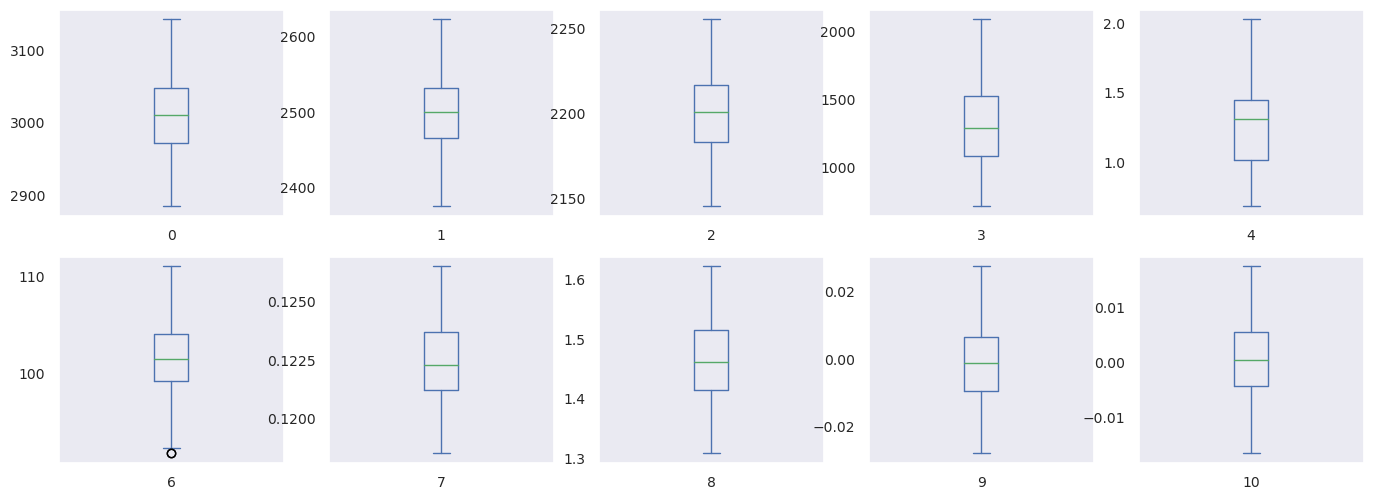

In [ ]:
x.iloc[:, :10].plot(kind='box', subplots=True,layout=(10,5), fontsize=10, figsize=(15,30));

### PCA

In [ ]:
print(x.shape)
print(y.shape)

(1586, 234)
(1586,)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1110, 234)
shape of x_test:  (476, 234)
shape of y_train:  (1110,)
shape of y_test:  (476,)


## PCA 적용

In [ ]:
scaler = MinMaxScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_train = pd.DataFrame(scaled_x_train, columns=col)

scaled_x_test = scaler.transform(x_test)
scaled_x_test = pd.DataFrame(scaled_x_test, columns=col)

In [ ]:
# Creating a covariance matrix
cov_matrix = np.cov(scaled_x_train.T)

#perform an eigendecomposition on the covariance matrix:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

#### Eigenvalues의 90% 이상을 포함할 수 있는 n_components를 설정

In [ ]:
tot = sum(eig_vals)
var_exp = [( i / tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

i = 0
while not (cum_var_exp[i] > 90):
    i = i+1

In [ ]:
print(f'Number of dimensions needed to capture 90% of variance:{i}')

Number of dimensions needed to capture 90% of variance:139


In [ ]:
# PCA with reduced number of components
pca = PCA(n_components=i,random_state=1)
pca.fit(scaled_x_train.values)
print(pca.components_)
pca_train_df= pd.DataFrame(pca.fit_transform(scaled_x_train))

[[ 0.00089577  0.00289244  0.01623317 ... -0.02295643  0.01027185
   0.0247875 ]
 [-0.01101146 -0.00243092  0.01299868 ... -0.02346062  0.02763737
   0.03622996]
 [-0.01189148  0.01793949  0.00193785 ... -0.03919181  0.00434962
   0.01438104]
 ...
 [-0.02013851 -0.04652694  0.07448841 ... -0.05722235 -0.04458937
   0.05507164]
 [-0.01784626 -0.02365556 -0.06846799 ...  0.07250737  0.08087307
  -0.03853733]
 [-0.03149604 -0.09364606  0.03081768 ...  0.00995257  0.03627425
   0.04563986]]


In [ ]:
pca_test_df = pca.transform(scaled_x_test)

In [ ]:
print(pca_train_df.shape)
print(pca_test_df.shape)

(1110, 139)
(476, 139)


### Imbalanced label 처리를 위한 Upsampling 진행

In [ ]:
Counter(signal['Pass/Fail'])

Counter({0: 1463, 1: 123})

In [ ]:
osmote = SMOTE()
Xs_train,ys_train = osmote.fit_resample(pca_train_df,y_train)
Xs_test,ys_test = pca_test_df, y_test

print(Counter(ys_train))

Counter({0.0: 1022, 1.0: 1022})


In [ ]:
model = XGBClassifier()
model.fit(Xs_train, ys_train)
y_pred = model.predict(Xs_test)

<AxesSubplot: >

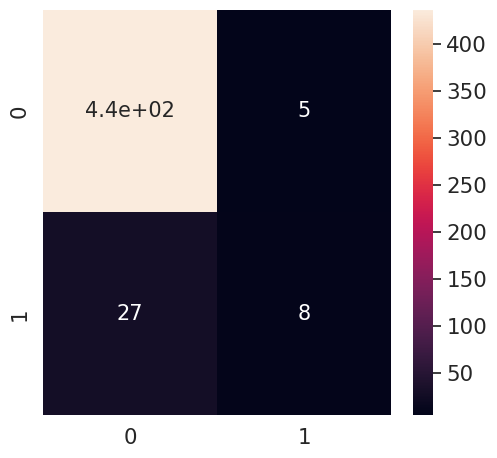

In [ ]:
cm = confusion_matrix(ys_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

#### Downsampling

In [ ]:
cc=ClusterCentroids(sampling_strategy=0.3)
Xcc_train,ycc_train = cc.fit_resample(pca_train_df,y_train)
Xcc_test,ycc_test   = pca_test_df, y_test

print(Counter(ycc_train))

/home/nas1_userB/daehoon/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Counter({0.0: 293, 1.0: 88})


In [ ]:
model = XGBClassifier(max_depth=5, eta=0.5, gamma=1, random_state=1)
model.fit(Xcc_train, ycc_train)
y_pred = model.predict(Xcc_test)

<AxesSubplot: >

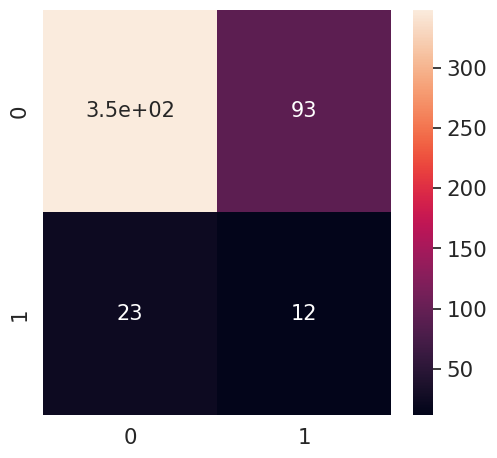

In [ ]:
cm = confusion_matrix(ycc_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

### Hyperparameter Tuning: Grid Search

In [ ]:
model = XGBClassifier()

In [ ]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'eta' : [0, 0.1, 0.2, 0.3, 0.4, 0.5],
               'gamma': [0, 1, 2, 3, 4, 5]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(Xcc_train, ycc_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [ ]:
print("Best Parameter: ", best_parameters)

Best Parameter:  {'eta': 0.3, 'gamma': 0, 'max_depth': 2}


In [ ]:
model = XGBClassifier(max_depth=2, eta=0.3, gamma=0)
model.fit(Xcc_train, ycc_train)
y_pred = model.predict(Xcc_test)

<AxesSubplot: >

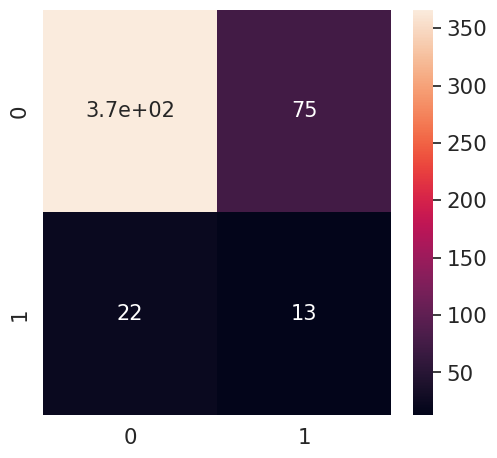

In [ ]:
cm = confusion_matrix(ycc_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

#### Feature Importance 확인하기

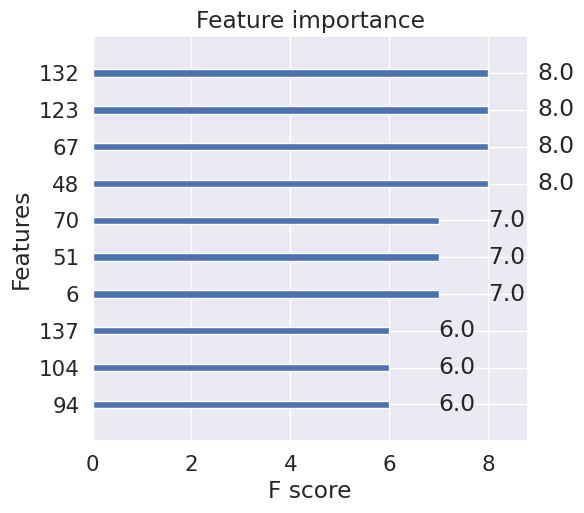

In [ ]:
xgb.plot_importance(model, max_num_features=10)
plt.show()

#### 제일 중요도가 높은 60개의 Feature만을 이용하여 모델을 재학습

In [ ]:
### ans start
important_idx = model.feature_importances_.argsort()[::-1][:60]
X_train_important = Xcc_train.iloc[:, important_idx]
X_test_important = Xcc_test[:, important_idx]

model_important = xgb.XGBClassifier()
model_important.fit(X_train_important, ycc_train)
### ans end

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(Xcc_test)

<AxesSubplot: >

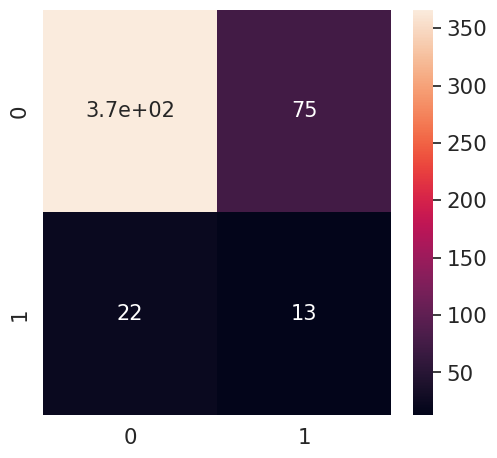

In [ ]:
cm = confusion_matrix(ycc_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})